# Age & Gender Dectection


# 1 Data preprocessing
# 2 From Unstructured data to Structured data
# 3 Plotting Images
# 4 Extracting Features
# 5 Normalizing data
# 6 Creating model
# 7 Training the model
# 8 Visualizing loss
# 9 Predicting test image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

0
[]


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task). So I split the image name on ' ' so I can get separated age and gender with image. Also, I have shuffle all the images

In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
image_path

[]

# From Unstructured data to Structured data

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [7]:
df.head()

,image,age,gender


In [8]:
gender_dict = {0:"Male",1:"Female"}

In [9]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [10]:
print(df.dtypes)

image     float64
age       float32
gender      int32
dtype: object


In [11]:
img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)

IndexError: index 1 is out of bounds for axis 0 with size 0

C:\Users\win8.1\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\win8.1\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\win8.1\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\win8.1\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<AxesSubplot:xlabel='age'>

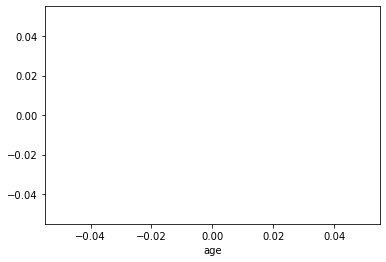

In [12]:
sns.distplot(df.age)

# Plotting Images

In [13]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


<Figure size 1080x1080 with 0 Axes>

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. I have already shuffled all the data to ensure no biasness in the dataset.

In [14]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

ValueError: With n_samples=0, test_size=0.85 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [15]:
train.head()

NameError: name 'train' is not defined

# Extracting Features

In [16]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)
C:\Users\Uzair Siddiqui\anaconda3\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"

  warnings.warn('grayscale is deprecated. Please use '

SyntaxError: unexpected character after line continuation character (Temp/ipykernel_1468/2421944552.py, line 12)

In [17]:
x_train.shape

NameError: name 'x_train' is not defined

# Normalizing data

In [19]:
x_train = x_train/255

NameError: name 'x_train' is not defined

In [20]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

NameError: name 'train' is not defined

In [21]:
input_size = (128,128,1)

# Creating model

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but I have implemented CNN with little Skip connections (shortcut).

In [22]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [23]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training the model

In [26]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

NameError: name 'x_train' is not defined

# Visualizing loss

In [27]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'model_history' is not defined

In [28]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'model_history' is not defined

# Predicting test image

In [29]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

NameError: name 'y_gender' is not defined

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

In [30]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

NameError: name 'y_gender' is not defined

# Inspired By Uzair Siddiqui(Kaggle)

Thank You..!!!!